In [1]:
import sys; print(sys.version)
import os
from collections import OrderedDict
import pickle

import numpy as np; print('numpy', np.__version__)
import scipy; print('scipy', scipy.__version__)
import pandas as pd; print('pandas',pd.__version__)
import allel; print('scikit-allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels; print('statsmodels', statsmodels.__version__)
import statsmodels.api as sm

from IPython.display import display, HTML

3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
numpy 1.26.0
scipy 1.12.0
pandas 2.1.1
scikit-allel 1.3.7
zarr 2.16.1
statsmodels 0.14.1


In [2]:
# %matplotlib inline
mpl.rcParams['figure.facecolor'] = '#BBBBBB'

In [3]:
# bit of code to showing all a dataframe
from IPython.display import display, HTML
def display_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        display(df)
def display_all_cols(df, max_rows=60):
    with pd.option_context('display.max_rows', max_rows, 'display.max_columns', None, 'display.width', None):
        display(df)

## Settings/Constants

In [4]:
SETNAME = 'AgamGF'
# SETNAME = 'AAEL'
# SETNAME = 'AAEL_Af'
# SETNAME = 'AAEL_Am'

# Analysis

In [5]:
# loading the data
print(SETNAME)
with open(f'{SETNAME}_potential_targets.pickle', 'rb') as fh:
    potential_targets, results_dict = pd.read_pickle(fh)
display(results_dict)

AgamGF


OrderedDict([('total genes in gtf', 13057),
             ('number of protein colding genes', 12563),
             ('total coding length [bp]', 21981057),
             ('overlapping CDSs with different gene ids', 18),
             ('Cas9 targets with unique location', 3932873),
             ('Cas9 targets pass MM flt', 1277823),
             ('Cas9 targets pass GC flt', 3531442),
             ('Cas9 targets pass Eff flt', 2422365),
             ('Cpf1 targets with unique location', 1535035),
             ('Cpf1 targets pass MM flt', 1351644),
             ('Cpf1 targets pass GC flt', 1005008),
             ('Cpf1 targets pass Eff flt', 487120),
             ('Cas9 targets hit CDS', 2829474),
             ('Cas9 targets pass all fileters', 516241),
             ('Cpf1 targets hit CDS', 646341),
             ('Cpf1 targets pass all fileters', 188834),
             ('number of samples', 182),
             ('vcf variants', 46881723),
             ('variants', 46881723),
             ('nucle

In [6]:
PREF = 0.99;

ng = results_dict['number of protein colding genes'] # convience

for mode in potential_targets.keys():
    print('####', mode, '####')
    t = potential_targets[mode]
    assert not t['gene_id'].isna().any(), "Target without a gene_id"

    # good targets
    tmp = t[t['p_ref']>=PREF].shape[0]
    print(f'num good targets: {tmp} ({100*tmp/t.shape[0]:.2f}%)')

    # num genes with >=1 potential target
    tmp = t['gene_id'].nunique()
    print(f'num genes with >= 1 potential target: {tmp} ({100*tmp/ng:.2f}%)')

    # num genes with >=1 good target
    tmp = t[t['p_ref']>=PREF]['gene_id'].nunique()
    print(f'num genes with >= 1 good target: {tmp} ({100*tmp/ng:.2f}%)')

#### Cas9 ####
num good targets: 114669 (22.21%)
num genes with >= 1 potential target: 11953 (95.14%)
num genes with >= 1 good target: 10403 (82.81%)
#### Cpf1 ####
num good targets: 37969 (20.11%)
num genes with >= 1 potential target: 11894 (94.67%)
num genes with >= 1 good target: 8291 (66.00%)


In [7]:
PREF = 0.99

ng = results_dict['number of protein colding genes'] # convience

tmp1 = potential_targets['Cas9']['gene_id'].unique()
tmp2 = potential_targets['Cpf1']['gene_id'].unique()
tmp = np.unique(np.concatenate((tmp1,tmp2))).shape[0]
print(f'num genes with >= 1 Cas9 or Cpf1 potential target: {tmp} ({100*tmp/ng:.2f}%)')

t = potential_targets['Cas9']
tmp1 = t[t['p_ref']>=PREF]['gene_id'].unique()
t = potential_targets['Cpf1']
tmp2 = t[t['p_ref']>=PREF]['gene_id'].unique()
tmp = np.unique(np.concatenate((tmp1,tmp2))).shape[0]
print(f'num genes with >= 1 Cas9 or Cpf1 good target: {tmp} ({100*tmp/ng:.2f}%)')

del tmp,tmp1,tmp2

num genes with >= 1 Cas9 or Cpf1 potential target: 12120 (96.47%)
num genes with >= 1 Cas9 or Cpf1 good target: 10745 (85.53%)


In [8]:
# construct dataframe of genes with target counts
tmp = np.unique(np.concatenate((potential_targets['Cas9']['gene_id'].unique(),potential_targets['Cpf1']['gene_id'].unique()))) # all genes with a target
tc = pd.DataFrame(index=sorted(tmp))
# add the good targets counts (potential targets counts are pref>=0)
for pref in [1, 0.99, 0.95, 0.90, 0.5,0]:
    tc = tc.join(potential_targets['Cas9'][potential_targets['Cas9']['p_ref']>=pref]['gene_id'].value_counts().rename(f'Cas9_{pref}'))
    tc = tc.join(potential_targets['Cpf1'][potential_targets['Cpf1']['p_ref']>=pref]['gene_id'].value_counts().rename(f'Cpf1_{pref}'))
# fill nulls/missing with 0
tc.fillna(0, inplace=True)
display(tc)

,Cas9_1,Cpf1_1,Cas9_0.99,Cpf1_0.99,Cas9_0.95,Cpf1_0.95,Cas9_0.9,Cpf1_0.9,Cas9_0.5,Cpf1_0.5,Cas9_0,Cpf1_0
AGAP000002,38.0,8.0,59.0,12.0,100.0,23.0,101.0,23.0,102.0,23.0,102.0,24.0
AGAP000005,20.0,7.0,21.0,7.0,28.0,8.0,28.0,8.0,28.0,8.0,28.0,8.0
AGAP000007,32.0,4.0,51.0,5.0,115.0,17.0,117.0,18.0,125.0,19.0,127.0,19.0
AGAP000008,4.0,2.0,8.0,3.0,27.0,12.0,29.0,13.0,31.0,14.0,31.0,14.0
AGAP000009,73.0,32.0,91.0,37.0,118.0,49.0,123.0,50.0,127.0,52.0,130.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...
AGAP029834,0.0,0.0,1.0,0.0,4.0,0.0,6.0,2.0,12.0,9.0,23.0,19.0
AGAP029835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0
AGAP029836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,21.0
AGAP029837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0


In [9]:
# Stats
PREF=0.99

ng = results_dict['number of protein colding genes'] # convience
def log_result(label, val, percent_base=None): # convience
    if percent_base is not None:
        print(f"{label} : {val} ({100*val/percent_base:0.2f}%)")
    results_dict[label] = val    


for mode in ['Cas9','Cpf1']:
    # x = (tc[f'{mode}_0']>0).sum()
    log_result(f"{mode} genes >= 1 potential target", (tc[f'{mode}_0']>0).sum(), ng)
    log_result(f"{mode} genes >= 1 good target", (tc[f'{mode}_{PREF}']>0).sum(), ng)


log_result("Cas9 or Cpf1 genes >= 1 potential target", tc[(tc['Cas9_0']>0) | (tc['Cpf1_0']>0)].shape[0], ng)
log_result("Cas9 or Cpf1 genes >= 1 good target", tc[(tc[f'Cas9_{PREF}']>0) | (tc[f'Cpf1_{PREF}']>0)].shape[0], ng)

log_result("Cas9==0 & Cpf1>=1 potential target", tc[(tc['Cas9_0']==0) & (tc['Cpf1_0']>0)].shape[0], ng)
log_result("Cas9>=1 & Cpf1==0 potential target", tc[(tc['Cas9_0']>0) & (tc['Cpf1_0']==0)].shape[0], ng)
log_result("Cas9>=1 & Cpf1>=1 potential target", tc[(tc['Cas9_0']>0) & (tc['Cpf1_0']>0)].shape[0], ng)

log_result("Cas9==0 & Cpf1>=1 good target", tc[(tc[f'Cas9_{PREF}']==0) & (tc[f'Cpf1_{PREF}']>0)].shape[0], ng)
log_result("Cas9>=1 & Cpf1==0 good target", tc[(tc[f'Cas9_{PREF}']>0) & (tc[f'Cpf1_{PREF}']==0)].shape[0], ng)
log_result("Cas9>=1 & Cpf1>=1 good target", tc[(tc[f'Cas9_{PREF}']>0) & (tc[f'Cpf1_{PREF}']>0)].shape[0], ng)

display(results_dict)

Cas9 genes >= 1 potential target : 11953 (95.14%)
Cas9 genes >= 1 good target : 10403 (82.81%)
Cpf1 genes >= 1 potential target : 11894 (94.67%)
Cpf1 genes >= 1 good target : 8291 (66.00%)
Cas9 or Cpf1 genes >= 1 potential target : 12120 (96.47%)
Cas9 or Cpf1 genes >= 1 good target : 10745 (85.53%)
Cas9==0 & Cpf1>=1 potential target : 167 (1.33%)
Cas9>=1 & Cpf1==0 potential target : 226 (1.80%)
Cas9>=1 & Cpf1>=1 potential target : 11727 (93.35%)
Cas9==0 & Cpf1>=1 good target : 342 (2.72%)
Cas9>=1 & Cpf1==0 good target : 2454 (19.53%)
Cas9>=1 & Cpf1>=1 good target : 7949 (63.27%)


OrderedDict([('total genes in gtf', 13057),
             ('number of protein colding genes', 12563),
             ('total coding length [bp]', 21981057),
             ('overlapping CDSs with different gene ids', 18),
             ('Cas9 targets with unique location', 3932873),
             ('Cas9 targets pass MM flt', 1277823),
             ('Cas9 targets pass GC flt', 3531442),
             ('Cas9 targets pass Eff flt', 2422365),
             ('Cpf1 targets with unique location', 1535035),
             ('Cpf1 targets pass MM flt', 1351644),
             ('Cpf1 targets pass GC flt', 1005008),
             ('Cpf1 targets pass Eff flt', 487120),
             ('Cas9 targets hit CDS', 2829474),
             ('Cas9 targets pass all fileters', 516241),
             ('Cpf1 targets hit CDS', 646341),
             ('Cpf1 targets pass all fileters', 188834),
             ('number of samples', 182),
             ('vcf variants', 46881723),
             ('variants', 46881723),
             ('nucle

In [10]:
# Specific genes
geneids = np.array([
['AGAP010929','AAEL019894','beta-tubulin85D'],
['AGAP010147','AAEL005656','Myosin heavy chain'],
['AGAP007280','AAEL027317','nudle'],
['AGAP005958','AAEL010848','Yellow-g'],
['AGAP004050','AAEL009114','double sex'],
['AGAP003899','AAEL011150','sex lethal'],
# ['AGAP011377',None,'?']
])

if SETNAME == 'AgamGF':
    setcol = 0
    geneids = np.append(geneids, [['AGAP011377',None,'?']], axis=0)
elif SETNAME.startswith('AAEL'):
    setcol = 1
else:
    raise ValueError(f"Unknown setname: {SETNAME}")

cols = ['Cas9_0','Cas9_0.99','Cas9_1', 'Cpf1_0','Cpf1_0.99','Cpf1_1']
tmp = tc.loc[geneids[:,setcol],cols].copy()
tmp['name'] = geneids[:,-1]
print(SETNAME)
display(tmp)

AgamGF


,Cas9_0,Cas9_0.99,Cas9_1,Cpf1_0,Cpf1_0.99,Cpf1_1,name
AGAP010929,13.0,8.0,4.0,2.0,0.0,0.0,beta-tubulin85D
AGAP010147,190.0,153.0,118.0,39.0,30.0,18.0,Myosin heavy chain
AGAP007280,157.0,3.0,0.0,53.0,2.0,0.0,nudle
AGAP005958,27.0,4.0,1.0,8.0,1.0,0.0,Yellow-g
AGAP004050,52.0,24.0,20.0,17.0,6.0,6.0,double sex
AGAP003899,25.0,17.0,8.0,6.0,3.0,0.0,sex lethal
AGAP011377,13.0,0.0,0.0,6.0,0.0,0.0,?


## Detailed information on targets hitting a single target

In [11]:
SETNAME = 'AgamGF'

# loading the data
print(SETNAME)
with open(f'{SETNAME}_potential_targets.pickle', 'rb') as fh:
    potential_targets, results_dict = pd.read_pickle(fh)

AgamGF


In [12]:
# Agam double sex
geneid = 'AGAP004050' # Agam double sex
PREF = 0

# female only transcript of interest coordinates 2R:48715295..48715161 (- strand, so complament)
exon_pos_start = 48715161  
exon_pos_end = 48715295

# *** @TCC WARNING: Just using both cutpos and cutneg... ignoring different possible effects depending on exon strand ***
t = potential_targets['Cas9'].query("gene_id == @geneid and p_ref > @PREF and ((cutpos > @exon_pos_start and cutpos < @exon_pos_end) or (cutneg > @exon_pos_start and cutneg < @exon_pos_end))")
display_all_cols(t)
print(t.shape)

t = potential_targets['Cpf1'].query("gene_id == @geneid and p_ref > @PREF and ((cutpos > @exon_pos_start and cutpos < @exon_pos_end) or (cutneg > @exon_pos_start and cutneg < @exon_pos_end))")
display_all_cols(t)
print(t.shape)

,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,MM0,MM1,MM2,MM3,Efficiency,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,vpos,nv,refAF,p_ref
1848034,28,TCAGGGGCATCATCTCCCACGGG,2R:48715224,+,60,0,0,0,0,0,0.64,AGAP004050-RA,AGAP004050,2R,48715224,48715241,48715241,True,0.0,0.0,True,True,True,1848034,[],0.0,[],1.0
1848037,91,CAATGGCTGTTGGAGAAACTCGG,2R:48715250,-,45,0,0,0,0,0,0.52,AGAP004050-RA,AGAP004050,2R,48715250,48715255,48715255,True,0.0,0.0,True,True,True,1848037,[],0.0,[],1.0


(2, 28)


,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,Efficiency,MM0,MM1,MM2,MM3,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,vpos,nv,refAF,p_ref
687440,15,TTTAGTATGACGTACATCAGGGGCATCA,2R:48715208,+,50,0,69,0,0,0,0,AGAP004050-RA,AGAP004050,2R,48715208,48715231,48715235,True,0.0,0.0,True,True,True,687440,[48715210],1.0,[0.01098901098901099],0.010989
687442,8,TTTCAGACGACGAGCTAGTGAAGCGAGC,2R:48715274,-,58,0,76,0,0,0,0,AGAP004050-RA,AGAP004050,2R,48715274,48715278,48715274,True,0.0,0.0,True,True,True,687442,[],0.0,[],1.000000


(2, 28)


In [13]:
SETNAME = 'AAEL'

# loading the data
print(SETNAME)
with open(f'{SETNAME}_potential_targets.pickle', 'rb') as fh:
    potential_targets, results_dict = pd.read_pickle(fh)

AAEL


In [14]:
# AAEL double sex
geneid = 'AAEL009114' # AAEL double sex
PREF = 0

# female only transcript of interest coordinates 1:233626559..233626693
exon_pos_start = 233626559
exon_pos_end = 233626693

# *** @TCC WARNING: Just using both cutpos and cutneg... ignoring different possible effects depending on exon strand ***
t = potential_targets['Cas9'].query("gene_id == @geneid and p_ref > @PREF and ((cutpos > @exon_pos_start and cutpos < @exon_pos_end) or (cutneg > @exon_pos_start and cutneg < @exon_pos_end))")
display_all_cols(t)
print(t.shape)

t = potential_targets['Cpf1'].query("gene_id == @geneid and p_ref > @PREF and ((cutpos > @exon_pos_start and cutpos < @exon_pos_end) or (cutneg > @exon_pos_start and cutneg < @exon_pos_end))")
display_all_cols(t)
print(t.shape)

,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,MM0,MM1,MM2,MM3,Efficiency,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,flt hitsCDS,vpos,nv,refAF,p_ref
683953,19,GTGATACTGAAAGGCGCCGACGG,1:233626636,+,55,0,0,0,0,0,0.63,AAEL009114-RB,AAEL009114,1,233626636,233626653,233626653,True,0.0,0.0,True,True,True,683953,True,"[233626641, 233626644, 233626653]",3.0,"[0.9858870967741935, 0.9919354838709677, 0.991...",0.970050
683955,38,ACGTCAATAAAGCGCGCCAACGG,1:233626661,+,50,0,0,0,0,0,0.55,AAEL009114-RB,AAEL009114,1,233626661,233626678,233626678,True,0.0,0.0,True,True,True,683955,True,"[233626668, 233626674, 233626677, 233626681]",4.0,"[0.9899193548387096, 0.9899193548387096, 0.997...",0.975993


(2, 29)


,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,Efficiency,MM0,MM1,MM2,MM3,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,flt hitsCDS,vpos,nv,refAF,p_ref
368345,5,TTTCAGACGACGAACTTGTCAAACGATC,1:233626553,+,46,0,79,0,0,0,0,AAEL009114-RB,AAEL009114,1,233626553,233626576,233626580,True,0.0,0.0,True,True,True,368345,True,"[233626560, 233626563, 233626566]",3.0,"[0.9979838709677419, 0.9939516129032258, 0.997...",0.989948


(1, 29)


In [15]:
# AAEL double sex
geneid = 'AAEL019894' # AAEL beta-tubulin85D
PREF = 0

# previous targets were in exon 1 (note gene is - strand) 2: 326338044..326337609
exon_pos_start = 326337609
exon_pos_end   = 326338044

# *** @TCC WARNING: Just using both cutpos and cutneg... ignoring different possible effects depending on exon strand ***
t = potential_targets['Cas9'].query("gene_id == @geneid and p_ref > @PREF and ((cutpos > @exon_pos_start and cutpos < @exon_pos_end) or (cutneg > @exon_pos_start and cutneg < @exon_pos_end))")
display_all_cols(t)
print(t.shape)

t = potential_targets['Cpf1'].query("gene_id == @geneid and p_ref > @PREF and ((cutpos > @exon_pos_start and cutpos < @exon_pos_end) or (cutneg > @exon_pos_start and cutneg < @exon_pos_end))")
display_all_cols(t)
print(t.shape)

,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,MM0,MM1,MM2,MM3,Efficiency,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,flt hitsCDS,vpos,nv,refAF,p_ref
1908403,2,GTGGTCCGTAAAGAATCCGAAGG,2:326337668,-,50,0,0,0,0,0,0.77,AAEL019894-RA,AAEL019894,2,326337668,326337673,326337673,True,0.0,0.0,True,True,True,1908403,True,[],0.0,[],1.000000
1908416,20,AATCTGGCGCCGGCAACAATTGG,2:326337742,-,55,0,0,0,0,0,0.53,AAEL019894-RA,AAEL019894,2,326337742,326337747,326337747,True,0.0,0.0,True,True,True,1908416,True,"[326337754, 326337760]",2.0,"[0.9959677419354839, 0.9979838709677419]",0.993960
1908425,23,GCTGTCCAAACGGTCCCGCTCGG,2:326337795,+,65,0,0,0,0,0,0.52,AAEL019894-RA,AAEL019894,2,326337795,326337812,326337812,True,0.0,0.0,True,True,True,1908425,True,"[326337799, 326337808, 326337811, 326337814]",4.0,"[0.9959677419354839, 0.9939516129032258, 0.995...",0.981976
1908439,4,TACTACAACGAGGCTACCGGAGG,2:326337875,-,55,0,0,0,0,0,0.71,AAEL019894-RA,AAEL019894,2,326337875,326337880,326337880,True,0.0,0.0,True,True,True,1908439,True,[],0.0,[],1.000000
1908443,19,CGGAGACAGCGATTTGCAGCTGG,2:326337912,-,60,1,0,0,0,0,0.55,AAEL019894-RA,AAEL019894,2,326337912,326337917,326337917,True,0.0,0.0,True,True,True,1908443,True,"[326337915, 326337916, 326337931]",3.0,"[0.9959677419354839, 0.9979838709677419, 0.868...",0.863703
1908444,9,GCTGTCTCCGCAATACGCCCCGG,2:326337925,+,65,0,0,0,0,0,0.64,AAEL019894-RA,AAEL019894,2,326337925,326337942,326337942,True,0.0,0.0,True,True,True,1908444,True,"[326337931, 326337937, 326337940]",3.0,"[0.8689516129032258, 0.9959677419354839, 0.872...",0.755522
1908446,26,GATGCCACCGGGGCGTATTGCGG,2:326337932,-,65,0,0,0,0,0,0.50,AAEL019894-RA,AAEL019894,2,326337932,326337937,326337937,True,0.0,0.0,True,True,True,1908446,True,"[326337937, 326337940, 326337952]",3.0,"[0.9959677419354839, 0.8729838709677419, 0.997...",0.867711
1908453,11,GATAGGAGCCAAGTTCTGGGAGG,2:326337978,-,55,0,0,0,0,0,0.62,AAEL019894-RA,AAEL019894,2,326337978,326337983,326337983,True,0.0,0.0,True,True,True,1908453,True,[326337985],1.0,[0.9959677419354839],0.995968


(8, 29)


,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,Efficiency,MM0,MM1,MM2,MM3,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,flt hitsCDS,vpos,nv,refAF,p_ref
1098868,16,TTTACGGACCACATCGAGTACCGAATCG,2:326337679,+,58,0,51,0,0,0,0,AAEL019894-RA,AAEL019894,2,326337679,326337702,326337706,True,0.0,0.0,True,True,True,1098868,True,[],0.0,[],1.000000
1098872,8,TTTGGAACCTGGCACTATGGATTCGGTC,2:326337817,-,54,0,62,0,0,0,0,AAEL019894-RA,AAEL019894,2,326337817,326337821,326337817,True,0.0,0.0,True,True,True,1098872,True,"[326337820, 326337835, 326337843]",3.0,"[0.9959677419354839, 0.9959677419354839, 0.997...",0.989952
1098874,6,TTTCCTCCGGTAGCCTCGTTGTAGTACA,2:326337872,+,54,0,63,0,0,0,0,AAEL019894-RA,AAEL019894,2,326337872,326337895,326337899,True,0.0,0.0,True,True,True,1098874,True,[],0.0,[],1.000000
1098877,4,TTTGGAACCGCTAGAAGTGCTCCAGGAT,2:326338043,-,54,1,67,0,0,0,0,AAEL019894-RA,AAEL019894,2,326338043,326338047,326338043,True,0.0,0.0,True,True,True,1098877,True,"[326338049, 326338058, 326338059, 326338062]",4.0,"[0.9858585858585859, 0.5826612903225806, 0.842...",0.483113


(4, 29)


## Full target information for good ones hitting genes of interest

In [16]:
display_all_cols(potential_targets['Cpf1'].head())

,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,Efficiency,MM0,MM1,MM2,MM3,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,flt hitsCDS,vpos,nv,refAF,p_ref
30,53,TTTACAGATCAGATGAGATGAATTGCGT,1:31685,+,42,0,57,0,0,0,0,AAEL012102-RA,AAEL012102,1,31685,31708,31712,True,0.0,0.0,True,True,True,30,True,"[31701, 31710]",2.0,"[0.9959514170040485, 0.9493927125506073]",0.945549
34,44,TTTCTCCTCCGATCAAAGGCAGCTGTCG,1:31726,-,58,0,60,0,0,0,0,AAEL012102-RA,AAEL012102,1,31726,31730,31726,True,0.0,0.0,True,True,True,34,True,[31738],1.0,[0.983739837398374],0.983740
36,38,TTTGATCGGAGGAGAAAACTTGATGGTA,1:31737,+,42,0,61,0,0,0,0,AAEL012102-RA,AAEL012102,1,31737,31760,31764,True,0.0,0.0,True,True,True,36,True,"[31738, 31756]",2.0,"[0.983739837398374, 0.8846153846153846]",0.870231
45,54,TTTAAATTCCAGAGGCTTGGTATTCGAT,1:31843,+,42,0,55,0,0,0,0,AAEL012102-RA,AAEL012102,1,31843,31866,31870,True,0.0,0.0,True,True,True,45,True,"[31852, 31858]",2.0,"[0.9979757085020243, 0.02631578947368421]",0.026263
46,4,TTTACTGGAGGTTGATCGAATACCAAGC,1:31857,-,50,0,80,0,0,0,0,AAEL012102-RA,AAEL012102,1,31857,31861,31857,True,0.0,0.0,True,True,True,46,True,[31858],1.0,[0.02631578947368421],0.026316


In [17]:
SETNAMES = ['AgamGF','AAEL','AAEL_Am','AAEL_Af']
PREF = 0.99;
MODE = 'Cpf1'

out = []

for SETNAME in SETNAMES:        

    print(SETNAME)
    with open(f'{SETNAME}_potential_targets.pickle', 'rb') as fh:
        potential_targets, results_dict = pd.read_pickle(fh)
    
    geneids = np.array([
    ['AGAP010929','AAEL019894','beta-tubulin85D'],
    ['AGAP010147','AAEL005656','Myosin heavy chain'],
    ['AGAP007280','AAEL027317','nudle'],
    ['AGAP005958','AAEL010848','Yellow-g'],
    ['AGAP004050','AAEL009114','double sex'],
    ['AGAP003899','AAEL011150','sex lethal'],
    # ['AGAP011377',None,'?']
    ])
    
    if SETNAME == 'AgamGF':
        setcol = 0
        geneids = np.append(geneids, [['AGAP011377',None,'?']], axis=0)
    elif SETNAME.startswith('AAEL'):
        setcol = 1
    else:
        raise ValueError(f"Unknown setname: {SETNAME}")

    for geneid,genedesc in geneids[:,(setcol,2)]:
        print('#'*40)
        out.append(potential_targets[MODE].query("gene_id == @geneid and p_ref > @PREF").copy())
        if out[-1].shape[0] > 0:
            out[-1].loc[:,'SET'] = SETNAME
            out[-1].loc[:,'gene_desc'] = genedesc
        print(SETNAME, geneid, genedesc, out[-1].shape[0], sep='\t')


pd.concat(out, ignore_index=True).to_excel(f'{MODE}_good_targets_in_genes_of_interest.xlsx')

display(pd.concat(out, ignore_index=True))

AgamGF
########################################
AgamGF	AGAP010929	beta-tubulin85D	0
########################################
AgamGF	AGAP010147	Myosin heavy chain	30
########################################
AgamGF	AGAP007280	nudle	2
########################################
AgamGF	AGAP005958	Yellow-g	1
########################################
AgamGF	AGAP004050	double sex	6
########################################
AgamGF	AGAP003899	sex lethal	3
########################################
AgamGF	AGAP011377	?	0
AAEL
########################################
AAEL	AAEL019894	beta-tubulin85D	4
########################################
AAEL	AAEL005656	Myosin heavy chain	15
########################################
AAEL	AAEL027317	nudle	1
########################################
AAEL	AAEL010848	Yellow-g	6
########################################
AAEL	AAEL009114	double sex	3
########################################
AAEL	AAEL011150	sex lethal	8
AAEL_Am
########################################
AAEL_Am	AA

,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,Efficiency,MM0,MM1,MM2,...,flt GC,flt Eff,idx,vpos,nv,refAF,p_ref,SET,gene_desc,flt hitsCDS
0,32,TTTCGTCTCGCTCGAGCAGAAGCGTATC,3R:49460572,+,58,2,66,0,0,0,...,True,True,1371157,[],0.0,[],1.000000,AgamGF,Myosin heavy chain,NaN
1,6,TTTCACCCAACACATAGCCCTCCTTCTC,3R:49460648,-,54,0,75,0,0,0,...,True,True,1371158,[],0.0,[],1.000000,AgamGF,Myosin heavy chain,NaN
2,71,TTTCGCAAGTGAATCCTCCGAAGTTTGA,3R:49461234,+,46,0,54,0,0,0,...,True,True,1371166,"[49461244, 49461250]",2.0,"[0.9945054945054945, 0.9972527472527473]",0.991773,AgamGF,Myosin heavy chain,NaN
3,4,TTTAGATAGGTCAGATCGGCCATATCTT,3R:49461270,-,46,0,76,0,0,0,...,True,True,1371171,[],0.0,[],1.000000,AgamGF,Myosin heavy chain,NaN
4,40,TTTGGAGTAGTATCGTTGGCGTAAGTTG,3R:49461316,-,46,0,62,0,0,0,...,True,True,1371172,[],0.0,[],1.000000,AgamGF,Myosin heavy chain,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,23,TTTCGTTAACTTCCTGTCCGAAGACGCG,3:193611366,-,54,2,62,0,0,0,...,True,True,1716278,[],0.0,[],1.000000,AAEL_Af,sex lethal,True
178,34,TTTCAGACTGGTTACAGTTACGGATTCG,3:193611395,-,46,1,55,0,0,0,...,True,True,1716279,[],0.0,[],1.000000,AAEL_Af,sex lethal,True
179,18,TTTCCACCGAACGTGCTACTCGAAGGCA,3:193625494,+,58,0,62,0,0,0,...,True,True,1716285,[],0.0,[],1.000000,AAEL_Af,sex lethal,True
180,32,TTTGATATGCCTTCGAGTAGCACGTTCG,3:193625501,-,50,0,55,0,0,0,...,True,True,1716286,[],0.0,[],1.000000,AAEL_Af,sex lethal,True


## Figures

In [18]:
# Figure showing loss of targets when accounting for population variation (potential -> good)
# Figure of # good targets with zoom (0-10) as inset
# Figure/table with # of good targets for the specific gene list

In [19]:
# load both AgamGF and AAEL results and compute tc for them
results_dicts = OrderedDict()
potential_targets_dfs = OrderedDict()
target_counts = OrderedDict()

for setname in ('AgamGF','AAEL','AAEL_Am','AAEL_Af'):        
    # loading the data
    print(setname)
    with open(f'{setname}_potential_targets.pickle', 'rb') as fh:
        potential_targets_dfs[setname], results_dicts[setname] = pd.read_pickle(fh)

    # construct dataframe of genes with target counts
    tmp = np.unique(np.concatenate((potential_targets_dfs[setname]['Cas9']['gene_id'].unique(),
                                    potential_targets_dfs[setname]['Cpf1']['gene_id'].unique()))) # all genes with a target
    tc = pd.DataFrame(index=sorted(tmp))
    # add the good targets counts (potential targets counts are pref>=0)
    for pref in [1, 0.99, 0.95, 0.90, 0.5,0]:
        tc = tc.join(potential_targets_dfs[setname]['Cas9'][potential_targets_dfs[setname]['Cas9']['p_ref']>=pref]['gene_id'].value_counts().rename(f'Cas9_{pref}'))
        tc = tc.join(potential_targets_dfs[setname]['Cpf1'][potential_targets_dfs[setname]['Cpf1']['p_ref']>=pref]['gene_id'].value_counts().rename(f'Cpf1_{pref}'))
    # fill nulls/missing with 0
    tc.fillna(0, inplace=True)
    target_counts[setname] = tc

AgamGF
AAEL
AAEL_Am
AAEL_Af


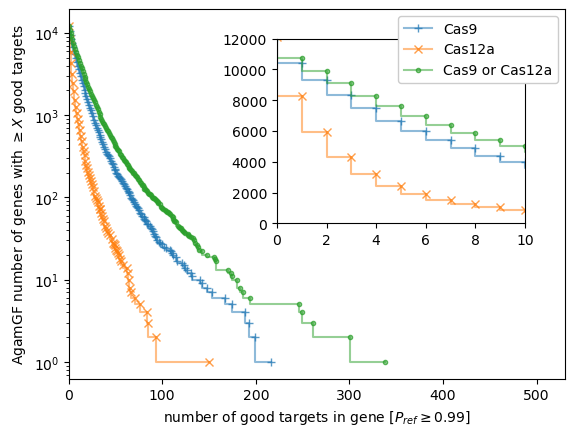

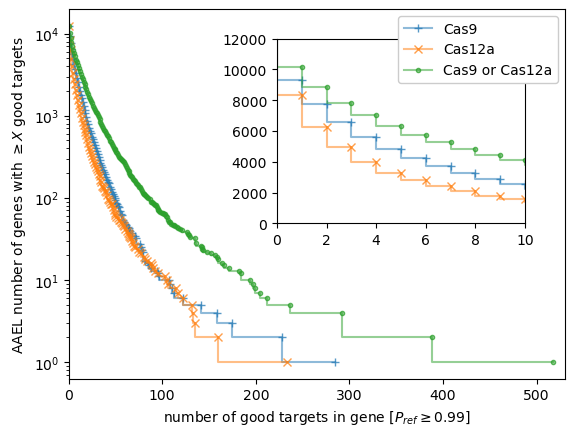

In [20]:
# Figure of # good targets with zoom (0-10) as inset
for setname in ['AgamGF', 'AAEL']:
    tc = target_counts[setname]
    PREF = 0.99

    def mkplot(ax, tc, PREF):
        x = tc[f'Cas9_{PREF}'].value_counts(normalize=False, sort=False, dropna=False).sort_index(ascending=False)
        ax.step(x.index, x.cumsum(),
                c = mpl.colors.colorConverter.to_rgba('C0', alpha=.5), marker='+',
                markeredgecolor = mpl.colors.colorConverter.to_rgba('C0', alpha=.75), 
                where='post', label='Cas9')

        x = tc[f'Cpf1_{PREF}'].value_counts(normalize=False, sort=False, dropna=False).sort_index(ascending=False)
        ax.step(x.index, x.cumsum(),
                c = mpl.colors.colorConverter.to_rgba('C1', alpha=.5), marker='x',
                markeredgecolor = mpl.colors.colorConverter.to_rgba('C1', alpha=.75), 
                where='post', label='Cas12a')

        x = tc[[f'Cas9_{PREF}',f'Cpf1_{PREF}']].sum(axis=1).value_counts(normalize=False, sort=False, dropna=False).sort_index(ascending=False)
        ax.step(x.index, x.cumsum(),
                c = mpl.colors.colorConverter.to_rgba('C2', alpha=.5), marker='.',
                markeredgecolor = mpl.colors.colorConverter.to_rgba('C2', alpha=.75), 
                where='post', label='Cas9 or Cas12a')


    fig, ax = mpl.pyplot.subplots(1,1, facecolor='white')
    mkplot(ax, tc, PREF)
    ax.set_ylabel(f'{setname} number of genes with $\geq X$ good targets')
    ax.set_xlabel(f'number of good targets in gene [$P_{{ref}} \geq {PREF}$]')

    ax.set_yscale('log')
    # ax.set_xlim([0,10])
    ax.set_xlim([0,530])

    axins = ax.inset_axes(
        [0.42, 0.42, 0.5, 0.5],
        xlim=(0, 10), ylim=(0, 12000))#, xticklabels=[], yticklabels=[])
    mkplot(axins, tc, PREF)

    ax.legend(framealpha=1)
    fig.savefig(f'{setname} good targets per gene overview.png') 
    fig.savefig(f'{setname} good targets per gene overview.svg') 

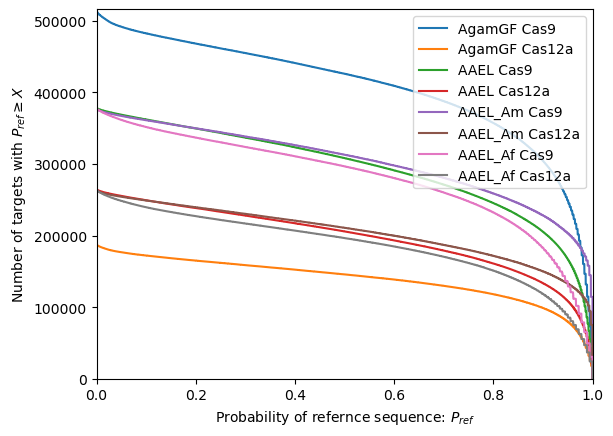

In [23]:
# Figure showing loss of targets when accounting for population variation (potential -> good)
from statsmodels.distributions.empirical_distribution import ECDF

PREF = 0.99
MODE_STR = {'Cas9':'Cas9', 'Cpf1':'Cas12a'}

fig, ax = mpl.pyplot.subplots(1,1, facecolor='white')

for si,setname in enumerate(potential_targets_dfs):
    t = potential_targets_dfs[setname]
    if si==1:
        ls = '--'
    else:
        ls = '-'
    
    
    for i,mode in enumerate(t.keys()):

        x = t[mode][f'p_ref'].sort_values(ascending=False)
        y = np.arange(len(x))#/float(len(x))
        # ax.step(x, y, where='post', color=f'C{i}', linestyle=ls, label=f'{setname} {mode}')
        ax.step(x, y, where='post', label=f'{setname} {MODE_STR[mode]}')
        ax.set_xlabel('Probability of refernce sequence: $P_{ref}$')
        ax.set_ylabel('Number of targets with $P_{ref} \geq X$' )

        # ax.axhline(y[x>=PREF].max(), linestyle=':', color=f'C{i}', lw=1)

    
# ax.axvline(PREF, linestyle=':', color='k', lw=1, label='good target threshold $p_{ref} \geq '+f'{PREF}$')    
ax.legend(loc='upper right')
ax.autoscale(enable=True, axis='both', tight=True)

# tmp = t['Cas9'][f'p_ref']
# res = ECDF(tmp)
# x = np.linspace(tmp.min(), tmp.max())
# y = 1-res(x)
# ax.plot(x,y)

In [22]:
display_all(potential_targets_dfs['AgamGF']['Cpf1'].iloc[10:15])

,Rank,Target sequence,Genomic location,Strand,GC content (%),Self-complementarity,Efficiency,MM0,MM1,MM2,MM3,transcript_id,gene_id,chrom,pos,cutpos,cutneg,flag unique location,MM3_num,sumMM,flt MM,flt GC,flt Eff,idx,vpos,nv,refAF,p_ref
86,25,TTTGCAGAGACAAGATTCACCTTCGGCT,2L:180957,+,50,0,60,0,0,0,0,AGAP004677-RA,AGAP004677,2L,180957,180980,180984,True,0.0,0.0,True,True,True,86,[],0.0,[],1.000000
138,1,TTTCGATTGAGACCAATGCTGAACATTC,2L:203879,+,42,0,88,0,0,0,0,AGAP004678-RA,AGAP004678,2L,203879,203902,203906,True,0.0,0.0,True,True,True,138,"[203883, 203897]",2.0,"[0.5467032967032966, 0.994475138121547]",0.543683
144,18,TTTGGCCGCATTGGCAGTACAAGCTTCA,2L:203993,-,54,0,60,0,0,0,0,AGAP004678-RA,AGAP004678,2L,203993,203997,203993,True,0.0,0.0,True,True,True,144,[204019],1.0,[0.9972527472527473],0.997253
145,13,TTTACATCACAACGAGGACAAGTGTATT,2L:204019,-,42,0,64,0,0,0,0,AGAP004678-RA,AGAP004678,2L,204019,204023,204019,True,0.0,0.0,True,True,True,145,"[204019, 204026]",2.0,"[0.9972527472527473, 0.9972527472527473]",0.994513
151,17,TTTCACTAGCGGAATGTATTGTGTGCGG,2L:204110,-,50,0,61,0,0,0,0,AGAP004678-RA,AGAP004678,2L,204110,204114,204110,True,0.0,0.0,True,True,True,151,[204117],1.0,[0.9862637362637363],0.986264
